<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover pattersn in visual data, e.g. the camera of a self-driving car.

## Dataset - Food 101 Kaggle
https://www.kaggle.com/datasets/dansbecker/food-101

This data-set was modified to only use 2 classes - pizza 🍕 and steak 🥩. 

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

### Importing the Data

In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-18 05:41:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  32.5MB/s    in 3.2s    

2023-02-18 05:41:42 (32.5 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### Inspecting the Data

I need to become one with the data. I need to build my own neural network in my brain (visualizing) before I start writing code.

In [2]:
!ls pizza_steak # list and run from command line

test  train


In [3]:
!ls pizza_steak/train/

pizza  steak


In [4]:
import os
# Walk through the pizza_steak directory and list number of files

for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.


In [5]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [6]:
# get teh classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train") # turning the folder into a path object
# Create a list of class-names from the sub-directories
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [7]:
print(class_names)

['pizza' 'steak']


In [8]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


In [9]:
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items in here
  print(random_image)

  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print (f"Image shape: {img.shape}") # show the shape of the image

  return img
  

['971934.jpg']
Image shape: (512, 512, 3)


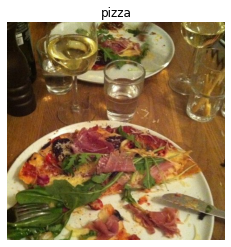

In [10]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/test/",
                        target_class="pizza")
 


In [11]:
img.shape

(512, 512, 3)

In [12]:
import tensorflow as tf

In [13]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 21,   8,   0],
        [ 25,  15,   6],
        [ 22,  12,   3],
        ...,
        [ 93,  81,  21],
        [ 94,  82,  24],
        [ 85,  70,  15]],

       [[ 22,   9,   0],
        [ 23,  13,   3],
        [ 20,  10,   0],
        ...,
        [ 87,  76,  14],
        [ 91,  79,  21],
        [ 92,  77,  20]],

       [[ 25,  12,   3],
        [ 23,  13,   3],
        [ 21,  11,   1],
        ...,
        [ 97,  86,  22],
        [ 86,  74,  14],
        [ 93,  78,  21]],

       ...,

       [[135, 144,  99],
        [141, 148, 104],
        [137, 144, 100],
        ...,
        [111,  85,  48],
        [109,  84,  44],
        [109,  84,  43]],

       [[152, 159, 115],
        [158, 165, 121],
        [156, 162, 118],
        ...,
        [102,  78,  40],
        [105,  82,  41],
        [108,  85,  43]],

       [[150, 157, 113],
        [159, 165, 121],
        [159, 164, 123],
        ...,
        [ 96,  72,  3

### Getting the data ready:
* Changing it to numerical format
* Scaling the data - get all the pixel values between 0 and 1

* 🔑 As we discussed before, many machine learning models prefer the values they work with to be between 0 and 1.

In [14]:
(img/255.).dtype

dtype('float64')

# An end-to-end example

Let's build a convolutional neural network to find patterns in our images. More specifically we need a way to:

* Load our images
* Preprocess our iamges
* Build a CNN to find patterns in our images
* Compile the CNN
* Fit the CNN to our training data

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
tf.random.set_seed(42)
# preprocess data (get all the pixel values between 0 & 1 i.e. scaling + normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up paths to our data directories
train_dir="/content/pizza_steak/train/"
test_dir="/content/pizza_steak/test/"






# import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)


# build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")                       
])



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [17]:
len(train_data), len(valid_data)

(47, 16)

This is 1500/32 = 46.875

* Notes on the code: 
* `flow_from_directory` takes a path to a directory and generates batches of augmented data. It creates data and labels automatically into a list.
* `class_mode` - states that it's a binary classification

In [18]:
# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        verbose=2,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 - 21s - loss: 0.6964 - accuracy: 0.5393 - val_loss: 0.6431 - val_accuracy: 0.5460 - 21s/epoch - 452ms/step
Epoch 2/5
47/47 - 10s - loss: 0.5329 - accuracy: 0.7233 - val_loss: 0.4086 - val_accuracy: 0.8240 - 10s/epoch - 221ms/step
Epoch 3/5
47/47 - 10s - loss: 0.4248 - accuracy: 0.8160 - val_loss: 0.4167 - val_accuracy: 0.8140 - 10s/epoch - 211ms/step
Epoch 4/5
47/47 - 9s - loss: 0.3921 - accuracy: 0.8353 - val_loss: 0.3205 - val_accuracy: 0.8680 - 9s/epoch - 201ms/step
Epoch 5/5
47/47 - 10s - loss: 0.3671 - accuracy: 0.8513 - val_loss: 0.3306 - val_accuracy: 0.8540 - 10s/epoch - 218ms/step
